In [ ]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.pooling import GlobalMaxPooling1D
from keras.layers import Bidirectional
from keras import initializers, regularizers, optimizers, layers
from keras.models import load_model
from sklearn import metrics
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras

In [ ]:
def loadData_Tokenizer(X_train, X_val, xtest,MAX_NB_chars=100,MAX_SEQUENCE_LENGTH=200):
    np.random.seed(7)
    text = np.array(X_train)

    alphabet="abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789-,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"
    char_dict = {}
    for i, char in enumerate(alphabet):
      char_dict[char] = i + 1
    
    print("characters of the dictionary are  ")
    print(char_dict)
    tokenizer = Tokenizer(num_words=MAX_NB_chars, char_level=True, oov_token='UNK')
    # Use char_dict to replace the tk.word_index
    tokenizer.word_index = char_dict 
    # Add 'UNK' to the vocabulary 
    tokenizer.word_index[tokenizer.oov_token] = max(char_dict.values()) + 1
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    vocab_size = len(tokenizer.word_index)+1

    embedding_weights= []
    embedding_weights.append(np.zeros(vocab_size))

    for char, i in tokenizer.word_index.items():
      onehot = np.zeros(vocab_size)
      onehot[i-1] = 1
      embedding_weights.append(onehot)
      embedding_weight = np.array(embedding_weights)

    sequences = tokenizer.texts_to_sequences(xtest)
    XTest = pad_sequences(sequences, maxlen=200)

    sequences = tokenizer.texts_to_sequences(X_val)
    X_val = pad_sequences(sequences, maxlen=200)

    print('Found %s unique tokens.' % len(word_index))
    indices = np.arange(text.shape[0])
    # np.random.shuffle(indices)
    X_train = text
    return (X_train, X_val, XTest, word_index,vocab_size, embedding_weight)

In [ ]:
def Build_Model_RCNN_Text(word_index, nclasses, VS,embedding_weight, MAX_SEQUENCE_LENGTH=200, EMBEDDING_DIM=57 ):

    kernel_size = 4
    filters = 100
    pool_size = 4
    gru_node = 128

    embed_size = EMBEDDING_DIM
    embedding_layer = Embedding(VS, embed_size, input_length=MAX_SEQUENCE_LENGTH,weights =[embedding_weight], trainable=True)

    model = Sequential()
    model.add(embedding_layer)
    model.add(Conv1D(filters=100, kernel_size=5,padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=100, kernel_size=4,padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=100, kernel_size=3,padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(128, return_sequences=True,name='lstm_layer',dropout=0.3,recurrent_dropout=0.5)))
    #model.add(Bidirectional(LSTM(128, return_sequences=True,name='lstm_layer',dropout=0.4,recurrent_dropout=0.5)))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(units=512, activation="relu",
    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),
    activity_regularizer=regularizers.l2(1e-5)))
    model.add(Dropout(rate=0.4))
    model.add(Dense(7, activation="softmax"))
    opt = keras.optimizers.Adam(learning_rate=0.0003,beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7,
    amsgrad=False,
    name="Adam")
    model.compile(loss='categorical_crossentropy',
                  optimizer= opt,
                  metrics=['accuracy'])

    return model

In [ ]:
def get_data_train():
  df = pd.read_csv('/content/traindata_intent2.csv')
  df.head()
  X=df['body']
  Y = df['intent_2'].astype("category")
  cat_types= Y.cat.categories
  Y_nids = Y.cat.codes
  Y = to_categorical(Y_nids, num_classes=7)
  return X, Y

In [ ]:
def get_data_val():
  df = pd.read_csv('/content/validationdata_intent2.csv')
  df.head()
  X=df['body']
  Y = df['intent_2'].astype("category")
  cat_types= Y.cat.categories
  Y_nids = Y.cat.codes
  Y = to_categorical(Y_nids, num_classes=7)
  return X, Y

In [ ]:
def get_data_test():
  df = pd.read_csv('/content/testdata_intent2.csv')
  df.head()
  X_t = df['body']
  Y = df['intent_2'].astype("category")
  cat_types= Y.cat.categories
  Y_nids = Y.cat.codes
  y_t = to_categorical(Y_nids, num_classes=7)
  return X_t, y_t

In [ ]:
X_train,y_train= get_data_train()
X_val,y_val= get_data_val()
X_test,y_test= get_data_test()


In [ ]:
XTrain, X_val, XTest, word_index, vocab_size, embedding_weight = loadData_Tokenizer(X_train,X_val,X_test)


characters of the dictionary are  
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, 'A': 27, 'B': 28, 'C': 29, 'D': 30, 'E': 31, 'F': 32, 'G': 33, 'H': 34, 'I': 35, 'J': 36, 'K': 37, 'L': 38, 'M': 39, 'N': 40, 'O': 41, 'P': 42, 'Q': 43, 'R': 44, 'S': 45, 'T': 46, 'U': 47, 'V': 48, 'W': 49, 'X': 50, 'Y': 51, 'Z': 52, '0': 53, '1': 54, '2': 55, '3': 56, '4': 57, '5': 58, '6': 59, '7': 60, '8': 61, '9': 62, '-': 86, ',': 64, ';': 65, '.': 66, '!': 67, '?': 68, ':': 69, "'": 70, '"': 71, '/': 72, '\\': 73, '|': 74, '_': 75, '@': 76, '#': 77, '$': 78, '%': 79, '^': 80, '&': 81, '*': 82, '~': 83, '`': 84, '+': 85, '=': 87, '<': 88, '>': 89, '(': 90, ')': 91, '[': 92, ']': 93, '{': 94, '}': 95}
Found 56 unique tokens.


In [ ]:
XTrain[1]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  8,  2, 19,  5,  4, 16, 11,  3, 12,
        2, 19, 11,  5,  4,  2, 10,  7, 13,  3,  2,  7, 17,  2,  4, 11,  3,
        2,  6,  3, 16, 15, 10,  8,  4, 18,  2, 19,  3,  8, 20, 11,  4,  2,
       10,  5,  9, 20,  3,  2,  8,  6,  2,  3, 37, 16,  3, 13, 13,  3,  9,
        4,  2,  5,  9, 12,  2,  8,  2,  4, 10, 18,  2,  4,  7,  2, 20,  3,
        4,  2,  4, 11,  3,  2, 13,  7, 19,  3,  6,  4,  2, 14,  5,  6,  6,
        2, 19,  8,  4, 11,  2,  5,  2,  6,  5, 17,  3,  4, 18,  2, 17,  5,
       16,  4,  7, 10,  2,  5, 10,  7, 15,  9, 12,  2, 29], dtype=int32)

In [ ]:
nclasses=3

model_CharRCNN = Build_Model_RCNN_Text(word_index, nclasses,vocab_size,embedding_weight)


model_CharRCNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 57)           3249      
                                                                 
 conv1d (Conv1D)             (None, 200, 100)          28600     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 100, 100)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 100)          40100     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 50, 100)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 50, 100)           3

In [ ]:
import tensorflow as tf

In [ ]:
dot_img_file = '/tmp/model_1.png'

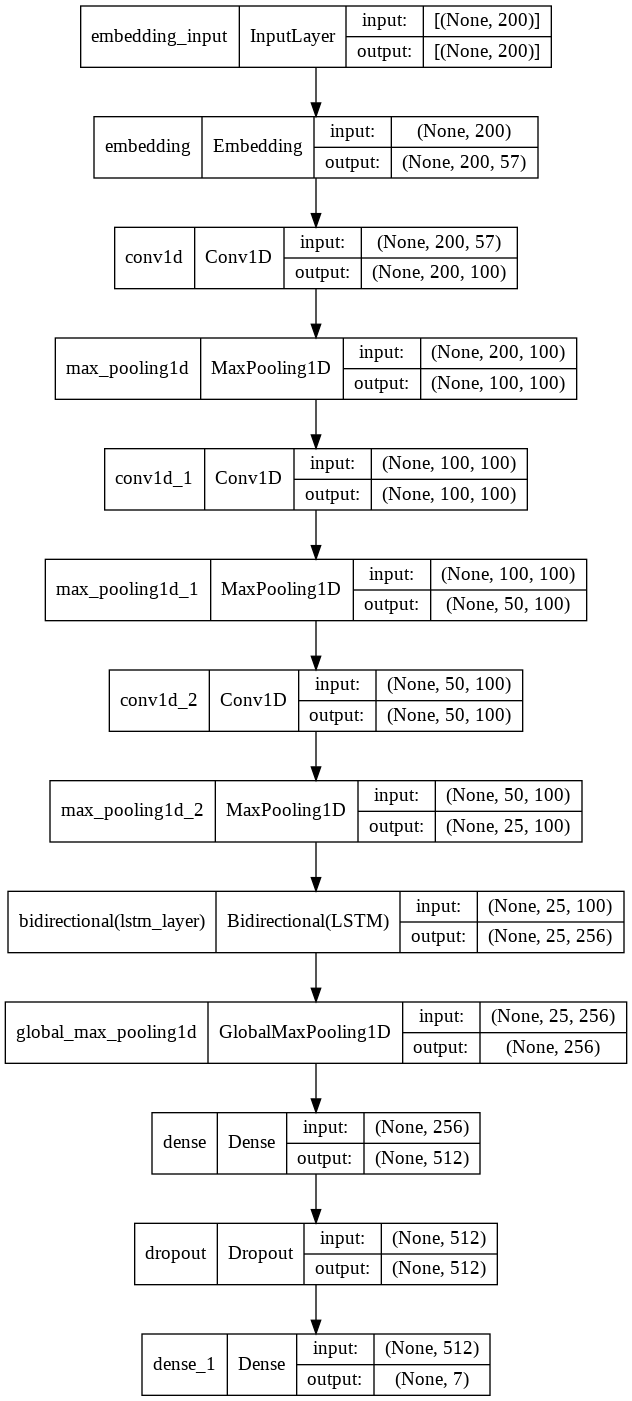

In [ ]:
tf.keras.utils.plot_model(model_CharRCNN, to_file=dot_img_file, show_shapes=True)

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/Data/Engine_design/CharCRNN/wgt/weights.hdf5', monitor='val_loss', verbose=2, save_best_only=True, save_weights_only=False, mode='auto', period=1)

model_CharRCNN.fit(XTrain, y_train,
                              validation_data=(X_val,y_val),
                              epochs=40,
                              batch_size=12,
                              verbose=2, callbacks=[checkpointer])

Epoch 1/40

Epoch 00001: val_loss improved from inf to 2.00629, saving model to /content/drive/MyDrive/Colab Notebooks/Data/Engine_design/CharCRNN/wgt/weights.hdf5
36/36 - 21s - loss: 2.0305 - accuracy: 0.1604 - val_loss: 2.0063 - val_accuracy: 0.1831 - 21s/epoch - 593ms/step
Epoch 2/40

Epoch 00002: val_loss improved from 2.00629 to 1.96587, saving model to /content/drive/MyDrive/Colab Notebooks/Data/Engine_design/CharCRNN/wgt/weights.hdf5
36/36 - 11s - loss: 1.9977 - accuracy: 0.1769 - val_loss: 1.9659 - val_accuracy: 0.2113 - 11s/epoch - 313ms/step
Epoch 3/40

Epoch 00003: val_loss improved from 1.96587 to 1.86013, saving model to /content/drive/MyDrive/Colab Notebooks/Data/Engine_design/CharCRNN/wgt/weights.hdf5
36/36 - 7s - loss: 1.9339 - accuracy: 0.2453 - val_loss: 1.8601 - val_accuracy: 0.2113 - 7s/epoch - 187ms/step
Epoch 4/40

Epoch 00004: val_loss improved from 1.86013 to 1.71839, saving model to /content/drive/MyDrive/Colab Notebooks/Data/Engine_design/CharCRNN/wgt/weights.

In [ ]:
# evaluate the test accuracy , call evaluate method and give the data 
_, train_acc = model_CharRCNN.evaluate(XTrain, y_train)
_, test_acc = model_CharRCNN.evaluate(XTest, y_test)

print("train acc", train_acc)
print("test acc", test_acc)

3/3 [==============================] - 0s 30ms/step - loss: 1.4345 - accuracy: 0.6761
train acc 0.9929245114326477
test acc 0.6760563254356384


In [ ]:
# take the class that is most likely to be the correct one based on model's opinion
y_pred = model_CharRCNN.predict(XTest)

In [ ]:
predicted = np.argmax(y_pred, axis=1)

In [ ]:
# model metrics to be defined 
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
 target_name = ['Dependencies between design parameters',
       'Effects of design parameters on objectives',
       'Exploration of design parameter values', 'Monitoring objective values',
       'NAN', 'Selected design parameter values for objective(s)',
       'Tradeoff between objectives']

In [ ]:
# print classification report 
print(metrics.classification_report(np.argmax(y_test, axis=1), predicted , target_names=target_name))

                                                   precision    recall  f1-score   support

           Dependencies between design parameters       0.89      0.89      0.89         9
       Effects of design parameters on objectives       0.67      0.55      0.60        11
           Exploration of design parameter values       0.50      0.70      0.58        10
                      Monitoring objective values       0.50      0.50      0.50        12
                                              NAN       0.82      0.75      0.78        12
Selected design parameter values for objective(s)       0.83      0.56      0.67         9
                      Tradeoff between objectives       0.70      0.88      0.78         8

                                         accuracy                           0.68        71
                                        macro avg       0.70      0.69      0.69        71
                                     weighted avg       0.69      0.68      0.68        

In [ ]:
# create a confusion matrix and chart it
cm = confusion_matrix(np.argmax(y_test, axis=1), predicted )
df_cm = pd.DataFrame(cm, index=target_name, columns=target_name)

In [ ]:
# data visualization at the time of data import and model metrics
import seaborn as sns
# we can set the parameters for each plot 
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc


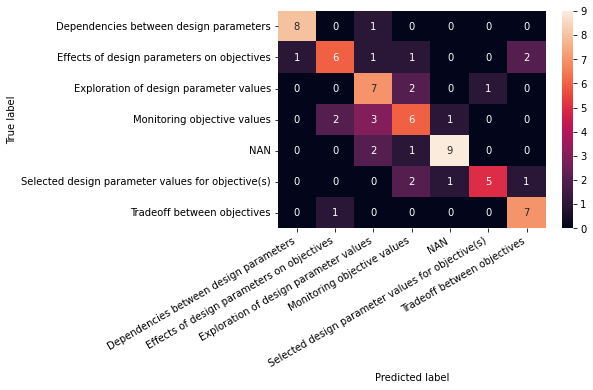

In [ ]:
# using a heatmap from seaborn to visualize the confusion matric
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');